In [ ]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from essentials import resample_data, add_labels
from extract_features import GenerateFeatures
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder



In [2]:
with open('data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)
with open('data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimate_dict = pickle.load(f)
    


Remove the data with the almost the entire data being void.
1. subj_9_void4
2. subj_11_void2

In [3]:
del imu_dict['subj_9_void4']
del imu_dict['subj_11_void2']

Resample the data

In [4]:
resampled_imu_dict = resample_data(imu_dict, 70)

41it [00:00, 364.76it/s]


Add the labels

In [5]:
labelled_imu_dict = {}
for i_void_instance, void_instance in tqdm(enumerate(resampled_imu_dict.keys()), desc="Adding labels to IMU data"):
    acc = resampled_imu_dict[void_instance]
    gt = ground_truth_dict[void_instance]
    
    labelled_imu_dict[void_instance] = add_labels(acc, gt)

Adding labels to IMU data: 41it [00:00, 322.73it/s]


Extract windowed features from the 3 axis of the accelerometer and the acceleration magnitude.
1. mean
2. rms
3. std
4. range
5. rms
6. variance
7. permutation entropy
8. spectral entropy

In [6]:
all_features = []
for exp_id, imu_data in enumerate(labelled_imu_dict.keys()):    
    # Extract features
    analyzer = GenerateFeatures(fs=70, window_duration=1.0, overlap=0.8)
    features, _ = analyzer.analyze_multi_axis_imu(labelled_imu_dict[imu_data])

    table = analyzer.create_summary_table()
    table['experiment_id'] = exp_id + 1  # Track source
    all_features.append(table)
    

final_features = pd.concat(all_features, ignore_index=True)

Analyzing :   0%|          | 0/4 [00:00<?, ?it/s]

Analyzing : 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


In [7]:
final_features.head()

,center_time,start_time,end_time,acc_x_permutation_entropy,acc_x_spectral_entropy,acc_x_mean,acc_x_std,acc_x_range,acc_x_rms,acc_x_var,...,acc_mag_std,acc_mag_range,acc_mag_rms,acc_mag_var,acc_mag_min,acc_mag_max,acc_mag_time_energy,acc_mag_spectral_energy,label,experiment_id
0,0.500000,0.000000,1.000000,0.865372,0.499289,0.936305,1.137581,5.41962,1.473349,1.294090,...,0.952641,4.247046,1.995090,0.907525,0.168266,4.415312,278.626807,19503.876521,pre-void,1
1,0.685714,0.185714,1.185714,0.816043,0.481647,0.989842,1.158399,5.41962,1.523704,1.341888,...,0.972284,4.247046,1.987835,0.945337,0.168266,4.415312,276.604259,19362.298164,pre-void,1
2,0.871429,0.371429,1.371429,0.822487,0.536058,1.195631,1.187488,5.41962,1.685130,1.410128,...,1.028004,4.247046,2.171321,1.056792,0.168266,4.415312,330.024516,23101.716142,pre-void,1
3,1.057143,0.557143,1.557143,0.792757,0.535459,1.251095,1.199598,5.41962,1.733284,1.439036,...,1.007495,4.247046,2.172495,1.015047,0.168266,4.415312,330.381288,23126.690133,pre-void,1
4,1.242857,0.742857,1.742857,0.792624,0.544907,1.165332,1.209628,5.41962,1.679642,1.463199,...,1.079930,4.247046,2.106117,1.166249,0.168266,4.415312,310.501137,21735.079605,pre-void,1


In [8]:
final_features.drop(['center_time', 'start_time', 'end_time'], axis=1, inplace=True)

View label distribution

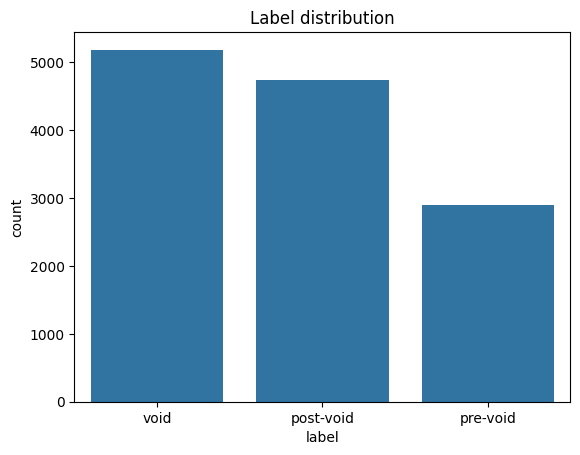

In [9]:
plt.figure()
sns.countplot(x = 'label',
              data = final_features,
              order = final_features.label.value_counts().index)
plt.title('Label distribution')
plt.show()

In [11]:
from sklearn.model_selection import GroupShuffleSplit

X = final_features.drop(columns=['label', 'experiment_id'])
y = final_features['label']
groups = final_features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [ ]:
# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Now train XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="multi:softprob",
    eval_metric='mlogloss',
    # early_stopping_rounds=10,
    # reg_alpha=0.1,   # L1 regularization
    # reg_lambda=1.0   # L2 regularization
    # n_jobs=1,             # <- Force single-threaded execution
    verbosity=0
)

eval_set = [(X_train, y_train_encoded), (X_test, y_test_encoded)]
model.fit(X_train, y_train_encoded, eval_set=eval_set, verbose=False)  # Use encoded labels

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,10
,enable_categorical,False
,eval_metric,'mlogloss'


In [14]:
# Classification report
y_pred = label_encoder.inverse_transform(model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   post-void       0.55      0.56      0.55      1463
    pre-void       0.35      0.33      0.34       631
        void       0.61      0.62      0.61      1325

    accuracy                           0.54      3419
   macro avg       0.50      0.50      0.50      3419
weighted avg       0.54      0.54      0.54      3419



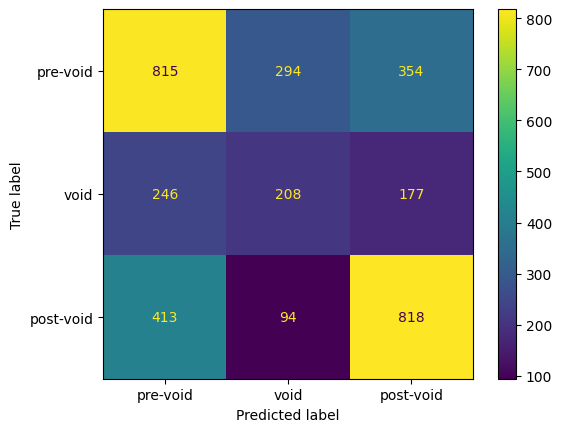

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['pre-void', 'void', 'post-void'])
cm_display.plot()
plt.show()

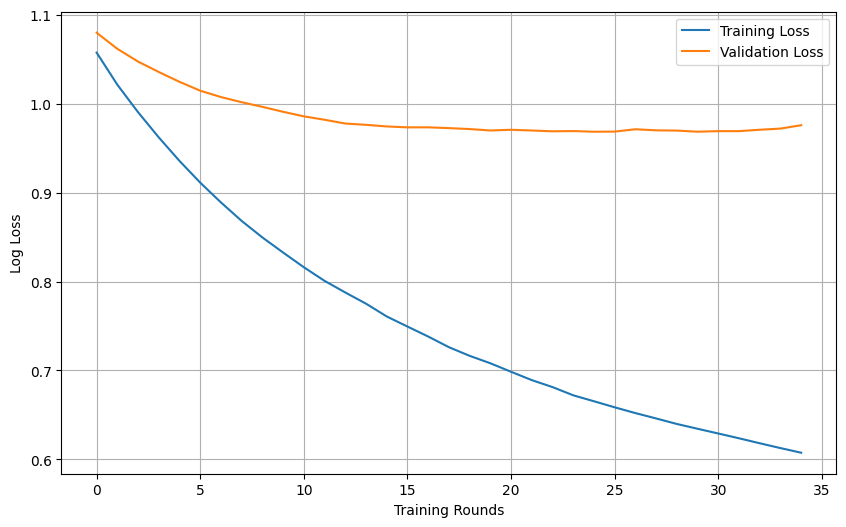

In [16]:
# Retrieve the evaluation results
results = model.evals_result()
train_loss = results['validation_0']['mlogloss']
test_loss = results['validation_1']['mlogloss']

# Plot the loss function
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.xlabel('Training Rounds')
plt.ylabel('Log Loss')
# plt.title('Loss')
plt.legend()
plt.grid(True)
plt.savefig('xgboost_loss_plot.png')